# Mean Reversion Trading Strategy
Mean Reversion is a popular trading strategy based on the assumption that asset prices oscillate around a historical average, or mean, and that prices that deviate significantly from this mean will eventually revert back toward it. In this notebook we show how you can backtest the strategy.

## Imports

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from tabulate import tabulate
from datetime import datetime

## Data
We'll use historical data from Yahoo Finance to apply our strategy. For this example, let's use Tesla's stock (TSLA).

### Download Data

In [171]:
# Define the stock symbol and the date range for our data
stock_symbol = 'TSLA'
start_date = '2024-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')  # Sets end date to today's date
print(f"Mean Reversion Trading for: {stock_symbol}\nStart Date: {start_date}\nEnd Date: {end_date}")

Mean Reversion Trading for: TSLA
Start Date: 2024-01-01
End Date: 2024-11-14


### Preprocess Data

In [172]:
df = yf.download(stock_symbol, start=start_date, end=end_date)

# Select the desired columns (first level of MultiIndex)
df.columns = df.columns.get_level_values(0)

# Keep only the columns you are interested in
df = df[['Open', 'Close', 'Volume', 'Low', 'High']]

# If the index already contains the dates, rename the index
df.index.name = 'Date'  # Ensure the index is named "Date"
    
# Resetting the index if necessary
df.reset_index(inplace=True)

# Ensure that the index is of type datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index again (in case it's reset)
df.set_index('Date', inplace=True)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Open,Close,Volume,Low,High
Date,,,,,
2024-01-02 00:00:00+00:00,250.080002,248.419998,104654200,244.410004,251.250000
2024-01-03 00:00:00+00:00,244.979996,238.449997,121082600,236.320007,245.679993
2024-01-04 00:00:00+00:00,239.250000,237.929993,102629300,237.729996,242.699997
2024-01-05 00:00:00+00:00,236.860001,237.490005,92379400,234.899994,240.119995
2024-01-08 00:00:00+00:00,236.139999,240.449997,85166600,235.300003,241.250000


### Visualize Chart

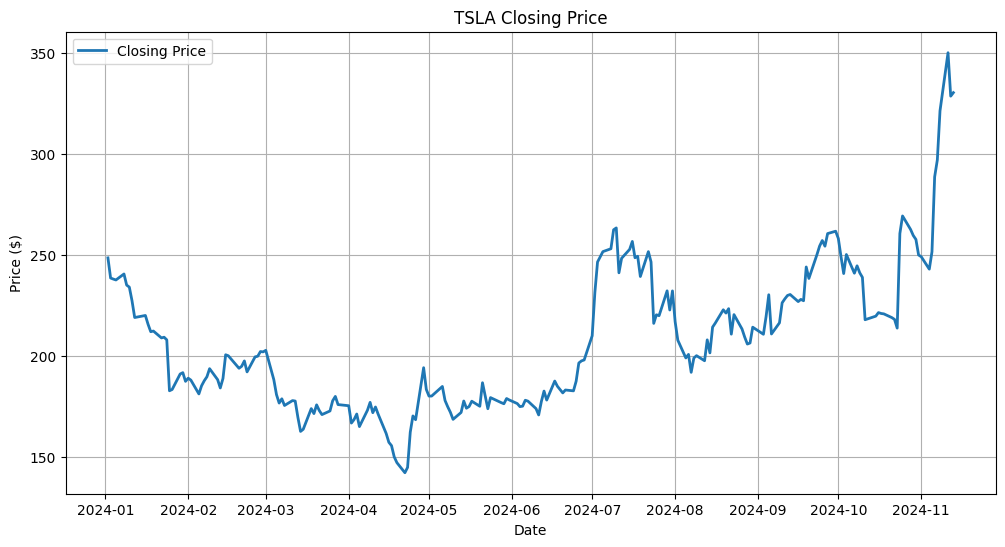

In [173]:
# Plot the closing price
plt.figure(figsize=(12, 6))

plt.plot(df['Close'], label='Closing Price', linewidth=2)

# Add title, labels, and legend
plt.title(f'{stock_symbol} Closing Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)

# Save the plot in 300dpi
plt.savefig(f'{stock_symbol}_stock_chart.png', dpi=300)

# Show the plot
plt.show()

## Calculate the Brokerage Fee
We define a function to calculate the brokerage fee for each transaction. The fee is set to 0.25% of the transaction amount, with a minimum fee of $0.01 to ensure that small transactions still incur a reasonable fee. This helps simulate the costs associated with trading, making the strategy more realistic.

In [174]:
# Define the fee calculation function
def calculate_fee(amount: float) -> float:
    """Calculate the brokerage fee based on transaction amount."""
    fee = amount * 0.0025  # 0.25% of the transaction
    return max(fee, 0.01)   # Minimum fee of $0.01

## Define Moving Averages and Signals

### Calculate Moving Averages

In [175]:
# Calculate the short and long EMAs
SHORT_WINDOW = 10
LONG_WINDOW = 30
df['SHORT_WINDOW'] = df['Close'].ewm(span=SHORT_WINDOW, adjust=False).mean()
df['LONG_WINDOW'] = df['Close'].ewm(span=LONG_WINDOW, adjust=False).mean()

### Generate Signals

In [176]:
# Define buy and sell signals based on the classic mean reversion strategy
df['Signal'] = 0  # Default to no signal

# Buy Signal: Short-term EMA is below long-term EMA, and price is below both
df['Signal'] = np.where(
    (df['SHORT_WINDOW'] < df['LONG_WINDOW']) & (df['Close'] < df['SHORT_WINDOW']) & (df['Close'] < df['LONG_WINDOW']), 1, df['Signal']
)

# Sell Signal: Short-term EMA is above long-term EMA, and price is above both
df['Signal'] = np.where(
    (df['SHORT_WINDOW'] > df['LONG_WINDOW']) & (df['Close'] > df['SHORT_WINDOW']) & (df['Close'] > df['LONG_WINDOW']), -1, df['Signal']
)

# Position change: +1 for buy, -1 for sell
df['Position'] = df['Signal'].diff()  # 1 = Buy, -1 = Sell

### Visualize Moving Averages

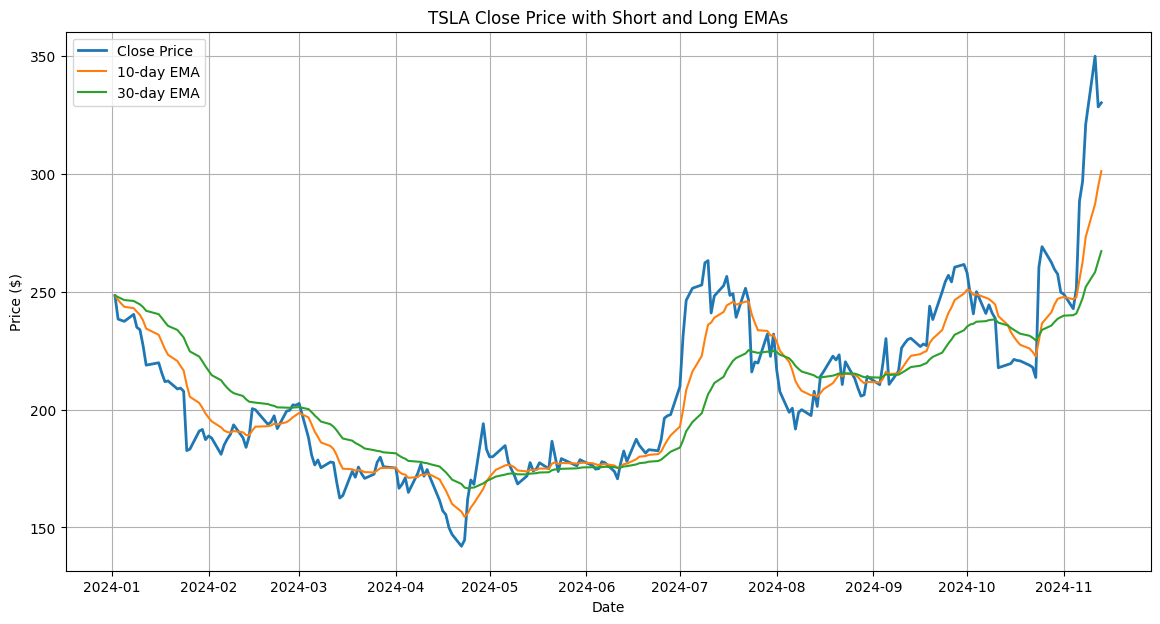

In [177]:
# Plot the Close Price and EMAs
plt.figure(figsize=(14, 7))

# Plot Close Price
plt.plot(df.index, df['Close'], label='Close Price', linewidth=2)

# Plot Short-term EMA
plt.plot(df.index, df['SHORT_WINDOW'], label=f'{SHORT_WINDOW}-day EMA')

# Plot Long-term EMA
plt.plot(df.index, df['LONG_WINDOW'], label=f'{LONG_WINDOW}-day EMA')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'{stock_symbol} Close Price with Short and Long EMAs')
plt.legend()
plt.grid(True)

# Save plot in 300dpi
plt.savefig(f'{stock_symbol}_moving_averages.png', dpi=300)

plt.show()

## Backtest the Strategy

In [178]:
# Initialize backtest parameters
initial_cash = 100
cash = initial_cash
shares = 0
transaction_details = []

# Backtest loop
for i in range(len(df)):
    # Buy signal: buy if `Position` changes to 1 and cash is available
    if df['Position'].iloc[i] == 1 and cash > 0:
        price = df['Close'].iloc[i]
        shares_to_buy = cash / price
        cost = shares_to_buy * price
        fee = calculate_fee(cost)
        total_cost = cost + fee

        if shares_to_buy > 0:
            cash -= total_cost
            shares += shares_to_buy
            transaction_details.append([df.index[i].date(), "BUY", round(price, 2), round(fee, 2), round(cash + shares * price, 2)])
    
    # Sell signal: sell if `Position` changes to -1 and shares are held
    elif df['Position'].iloc[i] == -1 and shares > 0:
        price = df['Close'].iloc[i]
        sale_value = shares * price
        fee = calculate_fee(sale_value)
        net_sale = sale_value - fee

        cash += net_sale
        transaction_details.append([df.index[i].date(), "SELL", round(price, 2), round(fee, 2), round(cash, 2)])
        shares = 0  # Reset shares after selling


In [179]:
# Final portfolio value
final_value = cash + (shares * df.iloc[-1]['Close'])
profit = final_value - initial_cash

# Summarize results using tabulate
print(tabulate(transaction_details, headers=["Date", "Action", "Price ($)", "Fee ($)", "Portfolio Value ($)"], tablefmt="pretty"))

# Final performance summary
print(f"\nInitial Portfolio Value: ${initial_cash:.2f}")
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Profit/Loss: ${profit:.2f}")

+------------+--------+-----------+---------+---------------------+
|    Date    | Action | Price ($) | Fee ($) | Portfolio Value ($) |
+------------+--------+-----------+---------+---------------------+
| 2024-01-03 |  BUY   |  238.45   |  0.25   |        99.75        |
| 2024-02-09 |  SELL  |  193.57   |   0.2   |        80.73        |
| 2024-02-12 |  BUY   |  188.13   |   0.2   |        80.52        |
| 2024-02-15 |  SELL  |  200.45   |  0.22   |        85.6         |
| 2024-02-23 |  BUY   |  191.97   |  0.21   |        85.38        |
| 2024-02-26 |  SELL  |   199.4   |  0.22   |        88.47        |
| 2024-03-04 |  BUY   |  188.14   |  0.22   |        88.25        |
| 2024-03-20 |  SELL  |  175.66   |  0.21   |        82.18        |
| 2024-03-21 |  BUY   |  172.82   |  0.21   |        81.97        |
| 2024-03-26 |  SELL  |  177.67   |  0.21   |        84.06        |
| 2024-04-01 |  BUY   |  175.22   |  0.21   |        83.85        |
| 2024-04-08 |  SELL  |  172.98   |  0.21   |   

## Plot the Strategy with Buy/Sell Signals
Finally, we plot the EMAs along with the buy and sell signals on a price chart for visualization.

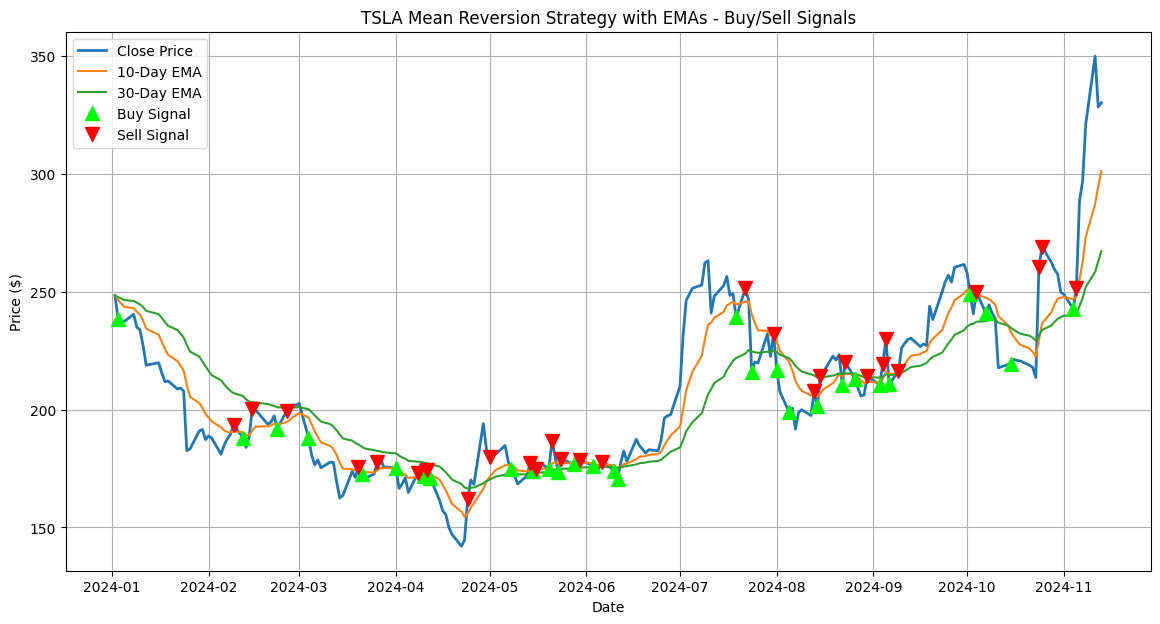

In [180]:
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price', linewidth=2)
plt.plot(df['SHORT_WINDOW'], label=f'{SHORT_WINDOW}-Day EMA')
plt.plot(df['LONG_WINDOW'], label=f'{LONG_WINDOW}-Day EMA')

# Plot Buy and Sell signals
buy_signals = df[df['Position'] == 1]
sell_signals = df[df['Position'] == -1]

plt.plot(buy_signals.index, buy_signals['Close'], '^', markersize=10, color='lime', label='Buy Signal')
plt.plot(sell_signals.index, sell_signals['Close'], 'v', markersize=10, color='r', label='Sell Signal')

plt.title(f"{stock_symbol} Mean Reversion Strategy with EMAs - Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend(loc='best')
plt.grid()

plt.savefig(f"{stock_symbol}_mean_reversion_strategy.png", dpi=300)
plt.show()
